In [4]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
data = pd.read_csv('gmm_1d.csv')

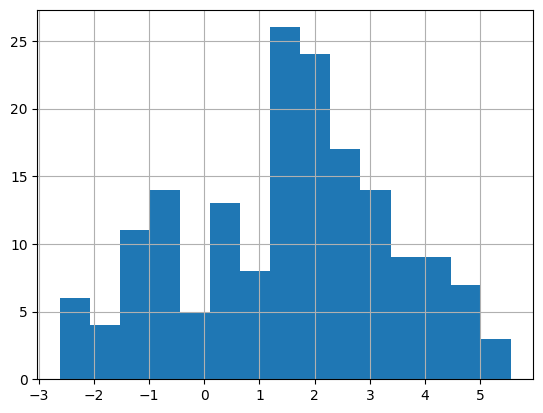

In [42]:
# data.groupby('z_i')['y_i'].hist(bins=15)
data['y_i'].hist(bins=15)
plt.show()

$$ y_i \sim p_y\left(y_i\right) $$
where
\begin{align}
    p_y\left(y_i\right) & = \sum_{k=0}^K p\left(y_i , z_i = k \right) \\ 
    & = \sum_{k=0}^K p\left(y_i \, \middle| \, z_i = k\right)p\left(z_i = k \right) \\ 
    & = \sum_{k=0}^K p\left(y_i \, \middle| \, z_i = k\right)p\left(z_i = k \right) \\ 
    & = \sum_{k=0}^K p\left(y_i \, \middle| \, z_i = k\right)\pi_{k} \\ 
    & = \sum_{k=0}^K q\left(y_i \, \middle| \, \mu_k, \sigma^2_k\right)\pi_{k} \\ 
\end{align}

In [212]:
def norm_pdf(y, mu, sigma):
    """Return the probability of observing y from a normal distribution with mean mu and scale sigma."""
    return torch.distributions.Normal(loc=mu, scale=sigma).log_prob(torch.tensor(y)).exp()

def norm_pdf_v(y, mu_vector, sigma_vector):
    """Return the probabilities of observing y under each univariate normal distribution specified by the means
    in mu and the scales in sigma."""
    return torch.tensor([
        torch.distributions.Normal(loc=mu_vector[i], scale=sigma_vector[i]).log_prob(torch.tensor(y)).exp()
        for i in range(len(mu_vector))
    ], dtype=torch.float)

def likelihood_obs(y, mu_k, sigma_k, pi_k):
    """Compute the likelihood for an observation under our current model."""
    return torch.dot(norm_pdf(y, mu_k, sigma_k), pi_k)

def likelihood_batch(Y, mu_k, sigma_k, pi_k):
    ll_accum = torch.tensor(0.0)
    
    for i in range(len(Y)):
        ll_accum = ll_accum + likelihood_obs(Y[i], mu_k, sigma_k, pi_k)
    return ll_accum    

# def penalty(mu):
#     """Assign a penalty (negative) if the mus get too close"""
#     p = 1/(mu[0] - mu[1]) + 1/(mu[0] - mu[2]) + 1/(mu[0] - mu[3]) + 1/(mu[1]-mu[2]) + 1/(mu[1] - mu[3]) + 1/(mu[2] - mu[3])
#     return p

In [225]:
K = torch.tensor(data['z_i'].nunique())

# Mixture weights (prior over mixture components)
pi_k = torch.distributions.Dirichlet(torch.tensor([1.0]*K)).sample()
pi_k.requires_grad = True

# Mixture means
# mu_k = torch.distributions.Normal(loc=data['y_i'].mean(), scale=data['y_i'].std()).sample([K])
# mu_k.requires_grad = True
mu_k = torch.tensor([-0.7, 0.9, 4.0, 2.0], requires_grad=True)

# Mixture scales
# sigma_k = torch.distributions.Uniform(low=1, high=3.0).sample([K])
# sigma_k.requires_grad = True
# sigma_k = torch.tensor([0.75, .75, 0.75, 0.75], requires_grad=True)
sigma_k = torch.tensor([0.75, 0.75, 0.75, 0.75], requires_grad=False)

import torch.nn.functional as F

n_data = data.shape[0]

step_scale = 0.02

num_epochs = 200
like_traj = torch.zeros(num_epochs, requires_grad=False)
pis = torch.zeros((num_epochs, K), requires_grad=False)
mus = torch.zeros((num_epochs, K), requires_grad=False)
sigmas = torch.zeros((num_epochs, K), requires_grad=False)


for epoch in range(200):

    # forward prop
    ll = likelihood_batch(data['y_i'].values, mu_k, sigma_k, pi_k)
    # backprop
    ll.backward()

    with torch.no_grad():
        # perform gradient ascent
        pi_k[:] = F.softmax(pi_k + step_scale * pi_k, dim=0)

        mu_k[:] = mu_k + step_scale * mu_k.grad         
        # sigma_k[:] = sigma_k + step_scale * sigma_k.grad
        # sigma_k[:] = torch.abs(sigma_k)

        pi_k.grad.zero_()
        mu_k.grad.zero_()
        # sigma_k.grad.zero_()


    # for i in range(n_data):
    #     # compute (current) likelihood
    #     ll = likelihood_obs(data['y_i'][i], mu_k, sigma_k, pi_k) #-  0.01 * penalty(mu_k)
        
    #     # Compute gradients (backprop)
    #     ll.backward()

    #     with torch.no_grad():
    #         # perform gradient ascent
    #         pi_k[:] = F.softmax(pi_k + step_scale * pi_k, dim=0)

    #         mu_k[:] = mu_k + step_scale * mu_k.grad         
    #         sigma_k[:] = sigma_k + step_scale * sigma_k.grad
    #         sigma_k[:] = torch.abs(sigma_k)

    #         pi_k.grad.zero_()
    #         mu_k.grad.zero_()
    #         sigma_k.grad.zero_()


    with torch.no_grad():
        # calculate likelihood of whole dataset
        like_traj[epoch] = likelihood_batch(data['y_i'].values, mu_k, sigma_k, pi_k)
        
        mus[epoch, :] = mu_k
        sigmas[epoch, :] = sigma_k
        pis[epoch, :] = pi_k

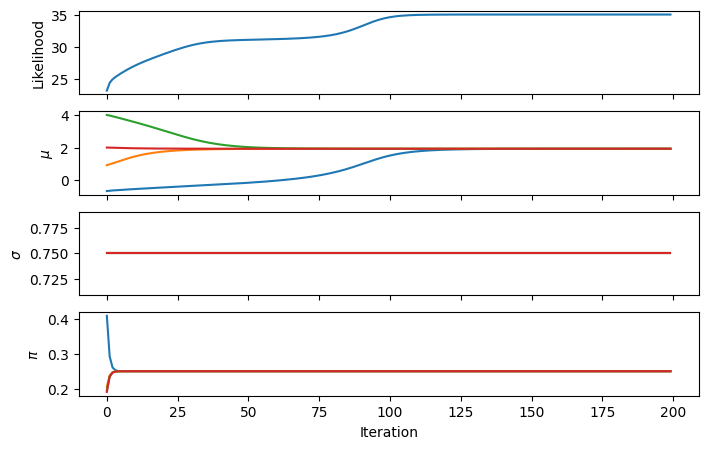

In [226]:
fig, ax = plt.subplots(nrows=4, figsize=(8, 5), sharex=True)

ax[0].plot(like_traj)

for k in range(4):
    ax[1].plot(mus[:,k], label=fr'$\mu_{k}$')
    ax[2].plot(sigmas[:,k], label=fr'$\sigma_{k}$')
    ax[3].plot(pis[:,k])
# ax[1].legend()
# ax[2].legend()
ax[1].set_ylabel(r"$\mu$")
ax[2].set_ylabel(r"$\sigma$")
ax[3].set_ylabel(r"$\pi$")

ax[0].set_ylabel('Likelihood')
ax[3].set_xlabel('Iteration')
plt.show()